In [ ]:

import pandas as pd
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import sys

# Add project root to path (for Jupyter notebooks)
# Get the current directory and navigate to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

from app.config import Config
from app.services import EDA
from app.services import PresentValue

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
## FROM DATABASE
pv = PresentValue()
anual_increment = pv.fetch_incremento_from_database()

fase = "III"
preproccesing = EDA()
df_raw = preproccesing.assemble_projects_from_database(fase)
df_vp = preproccesing.create_dataset(pv.present_value_costs, fase=fase)

c:\Code\Road-Project-Prediction\src\eda.py:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
import sqlite3
from app.config import Config

df_vp['COSTO_UF_VP'] = df_vp.loc[:, "1 - TRANSPORTE": ].sum(axis=1)

conn = sqlite3.connect(Config.DATABASE)
df_proyectos = pd.read_sql_query("SELECT codigo, anio_inicio, fase FROM proyectos", conn)
conn.close()

# Count functional units per project
df_vp['UF_COUNT'] = df_vp.groupby('CÓDIGO')['CÓDIGO'].transform('count')

# Aggregate by project - properly sum all functional units
# Group by CÓDIGO and aggregate different columns appropriately
df_project = df_vp.groupby('CÓDIGO').agg({
    'NOMBRE DEL PROYECTO': 'first',  # Take first (same for all rows)
    'ALCANCE': 'first',              # Take first (same for all rows)
    'LONGITUD KM': 'sum',            # Sum all functional units' lengths
    'COSTO_UF_VP': 'sum',            # SUM all functional units' costs (THIS IS KEY!)
    'UF_COUNT': 'first'              # Take first (same for all rows)
}).reset_index()

# Rename the aggregated cost column
df_project = df_project.rename(columns={'COSTO_UF_VP': 'COSTO_TOTAL_VP'})

# Merge with database info to get AÑO INICIO and FASE
df_project = df_project.merge(df_proyectos, left_on='CÓDIGO', right_on='codigo', how='left')

# Rename columns for clarity
df_project = df_project.rename(columns={
    'UF_COUNT': 'UNIDADES_FUNCIONALES',
    'anio_inicio': 'AÑO INICIO',
    'fase': 'FASE'
})

# Drop duplicate codigo column
df_project = df_project.drop(columns=['codigo'])

# Format cost values for display (in millions)
df_project['COSTO_MILLONES'] = df_project['COSTO_TOTAL_VP'] / 1_000_000

# Build hover_data dictionary
hover_dict = {
    'NOMBRE DEL PROYECTO': True,
    'CÓDIGO': True,
    'AÑO INICIO': True,
    'FASE': True,
    'ALCANCE': True,
    'UNIDADES_FUNCIONALES': True,
    'LONGITUD KM': ':.2f',
    'COSTO_MILLONES': ':.2f',
    'COSTO_TOTAL_VP': ':,.0f'
}

# Create the plot
fig = px.scatter(
    df_project,
    x='LONGITUD KM',
    y='COSTO_MILLONES',
    color='CÓDIGO',
    hover_data=hover_dict,
    labels={
        'LONGITUD KM': 'Longitud del Proyecto (km)',
        'COSTO_MILLONES': 'Valor Presente de la Causación de Personal (Millones COP)',
        'NOMBRE DEL PROYECTO': 'Nombre del Proyecto',
        'CÓDIGO': 'Código del Proyecto',
        'AÑO INICIO': 'Año de Inicio',
        'FASE': 'Fase del Proyecto',
        'ALCANCE': 'Alcance',
        'UNIDADES_FUNCIONALES': 'N° Unidades Funcionales',
        'COSTO_TOTAL_VP': 'Costo Total VP (COP)'
    },
    title='<b>Valor Presente de la Causación de Personal en Proyectos Viales</b><br><sub>Relación entre Longitud del Proyecto y Causación Total</sub>',
    template='plotly_white',
    size='COSTO_MILLONES',
    size_max=40,
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Enhance the visual design
fig.update_traces(
    marker=dict(
        line=dict(width=1.5, color='white'),
        opacity=0.85,
        sizemin=8
    ),
    textposition='top center'
)

# Update layout for executive presentation
fig.update_layout(
    font=dict(family="Arial, sans-serif", size=12, color="#2c3e50"),
    title=dict(
        font=dict(size=18, color="#1a252f", family="Arial Black"),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        showgrid=True,
        gridcolor='#ecf0f1',
        zeroline=False,
        title_font=dict(size=14, color="#34495e", family="Arial"),
        tickfont=dict(size=11)
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='#ecf0f1',
        zeroline=False,
        title_font=dict(size=14, color="#34495e", family="Arial"),
        tickfont=dict(size=11)
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='closest',
    legend=dict(
        title=dict(text='<b>Código Proyecto</b>', font=dict(size=12)),
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02,
        bgcolor="rgba(255, 255, 255, 0.9)",
        bordercolor="#bdc3c7",
        borderwidth=1
    ),
    margin=dict(l=80, r=200, t=100, b=80),
    height=600,
    width=1200
)

# Add a trend line for better insights
from sklearn.linear_model import LinearRegression
X = df_project[['LONGITUD KM']].values
y = df_project['COSTO_MILLONES'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Sort for line plot
sort_idx = X.flatten().argsort()
fig.add_trace(
    go.Scatter(
        x=X[sort_idx].flatten(),
        y=y_pred[sort_idx],
        mode='lines',
        name='Tendencia Lineal',
        line=dict(color='#e74c3c', width=2, dash='dash'),
        showlegend=True,
        hovertemplate='Línea de Tendencia<extra></extra>'
    )
)

fig.show()

In [35]:
target_columns = ['2.2 - TRAZADO Y DISEÑO GEOMÉTRICO', '2.3 - SEGURIDAD VIAL', '2.4 - SISTEMAS INTELIGENTES', 
                  '5 - TALUDES', '6 - PAVIMENTO', '7 - SOCAVACIÓN', '11 - PREDIAL', 
                  '12 - IMPACTO AMBIENTAL', '15 - OTROS - MANEJO DE REDES', '16 - DIRECCIÓN Y COORDINACIÓN']

df_per_km = preproccesing.calculate_cost_per_km(df_vp, target_columns)

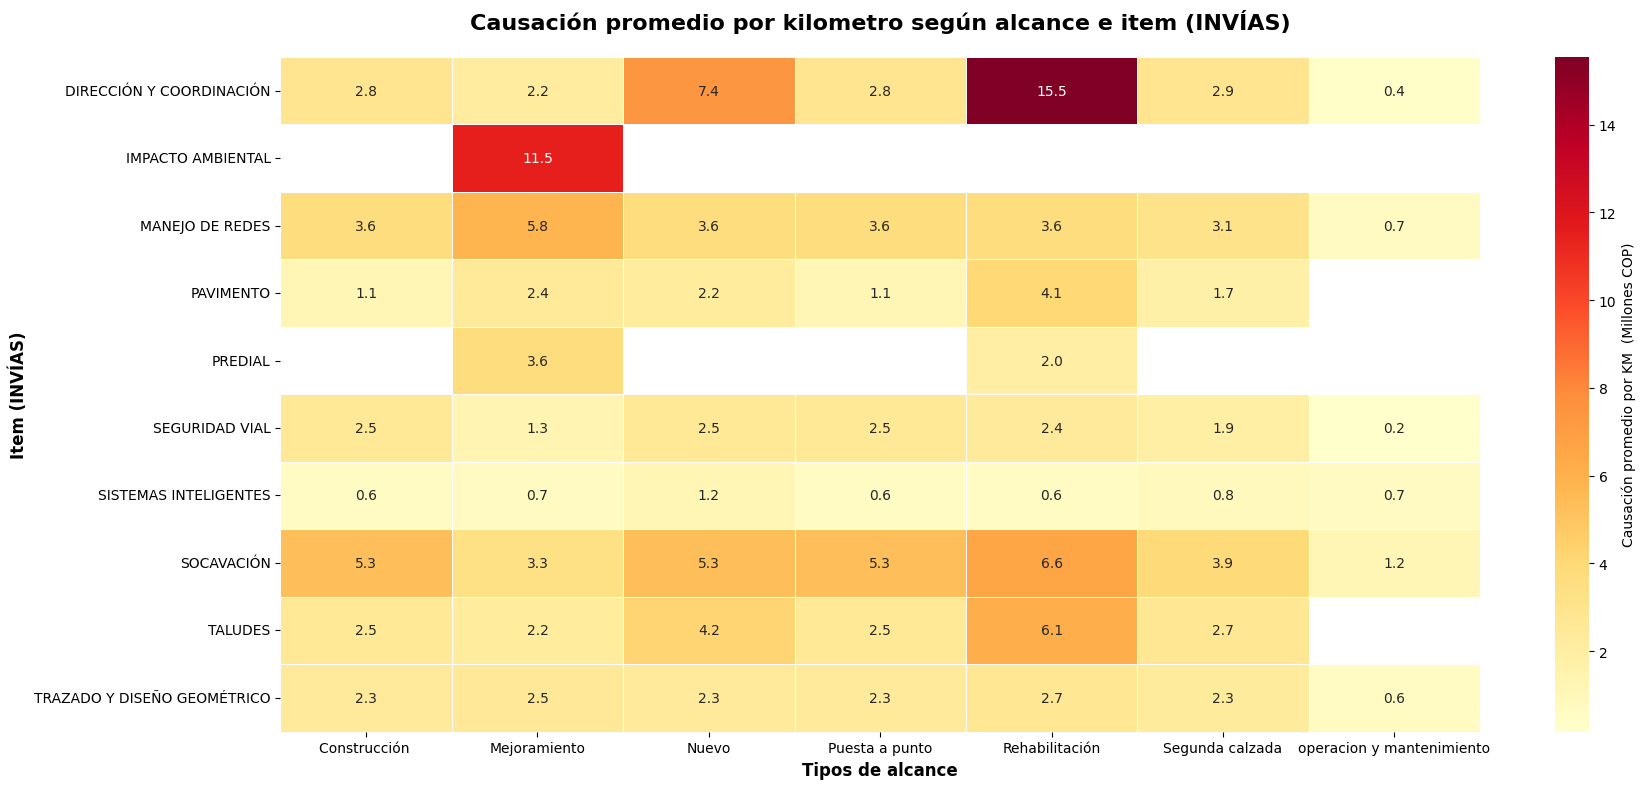

,Category,Alcance,Mean (M),Median (M),Std (M),Min (M),Max (M),Count
55,DIRECCIÓN Y COORDINACIÓN,Construcción,2.819275,2.819275,NaN,2.819275,2.819275,1
53,DIRECCIÓN Y COORDINACIÓN,Mejoramiento,2.190099,0.811868,4.093324e+00,0.811868,15.123599,12
51,DIRECCIÓN Y COORDINACIÓN,Nuevo,7.378554,7.378554,6.447794e+00,2.819275,11.937833,2
56,DIRECCIÓN Y COORDINACIÓN,Puesta a punto,2.819275,2.819275,2.489064e-16,2.819275,2.819275,8
54,DIRECCIÓN Y COORDINACIÓN,Rehabilitación,15.544567,24.028095,1.161655e+01,2.819275,24.028095,5
50,DIRECCIÓN Y COORDINACIÓN,Segunda calzada,2.914059,2.819275,2.099417e+00,0.350505,9.850822,20
52,DIRECCIÓN Y COORDINACIÓN,operacion y mantenimiento,0.350505,0.350505,4.115903e-17,0.350505,0.350505,3
42,IMPACTO AMBIENTAL,Mejoramiento,11.499786,11.499786,1.579550e+01,0.330677,22.668894,2
48,MANEJO DE REDES,Construcción,3.604718,3.604718,NaN,3.604718,3.604718,1
45,MANEJO DE REDES,Mejoramiento,5.802251,5.802251,NaN,5.802251,5.802251,1


In [37]:
def summarize_cost_per_km_by_alcance(df, target_columns, hue_column='ALCANCE'):
    summary_data = []
    
    for col in target_columns:
        per_km_col = f'{col} per KM'
        df_clean = df[df[per_km_col] > 0]
        
        for alcance in df_clean[hue_column].unique():
            subset = df_clean[df_clean[hue_column] == alcance][per_km_col]
            
            summary_data.append({
                'Category': col.split(' - ')[-1] if ' - ' in col else col.split(' ', 1)[1],
                'Alcance': alcance,
                'Mean (M)': subset.mean() / 1e6,
                'Median (M)': subset.median() / 1e6,
                'Std (M)': subset.std() / 1e6,
                'Min (M)': subset.min() / 1e6,
                'Max (M)': subset.max() / 1e6,
                'Count': len(subset)
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    fig, ax = plt.subplots(figsize=(18, 8))
    pivot_mean = summary_df.pivot(index='Category', columns='Alcance', values='Mean (M)')
    
    sns.heatmap(pivot_mean, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, 
                cbar_kws={'label': 'Causación promedio por KM  (Millones COP)'}, linewidths=0.5)
    ax.set_title('Causación promedio por kilometro según alcance e item (INVÍAS)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Tipos de alcance', fontsize=12, fontweight='bold')
    ax.set_ylabel('Item (INVÍAS)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return summary_df.sort_values(['Category', 'Alcance'])

summary = summarize_cost_per_km_by_alcance(df_per_km, target_columns)
summary
